# 2024C1-01 SMI WAXS TReXS core films plotting notebook

In [ ]:
# !pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory

## Imports

In [1]:
import PyHyperScattering as phs
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.auto import tqdm 
import subprocess
import io
import gc
print(phs.__version__)

/nsls2/users/alevin/repos/PyHyperScattering/src/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator


0.2.1+148.g206a2f6


In [2]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

## Define paths

In [3]:
# Define paths
propPath = pathlib.Path('/nsls2/data/smi/proposals/2024-1/pass-314903')
outPath = propPath.joinpath('processed_data')
sampleZarrsPath = outPath.joinpath('zarrs/waxs_core_films_trexs_sample_zarrs')

rawPaths = propPath.joinpath('raw_04')
waxsPath = rawPaths.joinpath('900KW')

In [4]:
# def make_para_perp_DAs(DS, sample_name, theta=90, chi_width=90):
#     # select dataarray to plot
#     DA = DS.sel(sample_name=sample_name)['flatfield_corr']
#     sel_DA = DA.sel(theta=theta)

#     # calculate ISI dataarrays
#     para_DA = sel_DA.rsoxs.slice_chi(0, chi_width=(chi_width/2))
#     perp_DA = sel_DA.rsoxs.slice_chi(-90, chi_width=(chi_width/2))
        
#     return para_DA, perp_DA

In [5]:
def make_para_perp_DAs(DA, chi_width=90):
    # calculate ISI dataarrays
    para_DA = DA.rsoxs.slice_chi(0, chi_width=(chi_width/2))
    perp_DA = DA.rsoxs.slice_chi(-90, chi_width=(chi_width/2))
        
    return para_DA, perp_DA

### Rclone copy statement

### Load whole dataset from zarr(s)

In [ ]:
unique_sample_names = sorted(set(['_'.join(f.name.split('_')[1:3]) for f in sampleZarrsPath.glob('*')]))
unique_sample_names

In [6]:
unique_sample_names = ['BareSiN_01', 'PM6_CB', 'PM6_p5CN-CB', 'PM6_1CN-CB', 'PM6_5CN-CB', 'PM6_CF', 'PM6_p5CN-CF', 'PM6_1CN-CF', 'PM6_5CN-CF']
unique_sample_names

['BareSiN_01',
 'PM6_CB',
 'PM6_p5CN-CB',
 'PM6_1CN-CB',
 'PM6_5CN-CB',
 'PM6_CF',
 'PM6_p5CN-CF',
 'PM6_1CN-CF',
 'PM6_5CN-CF']

In [ ]:
unique_sample_names = ['BareSiN_01', 'PM6_CF', 'PM6_p5CN-CF', 'PM6_1CN-CF', 'PM6_5CN-CF']
unique_sample_names

In [7]:
recip_DS_rows = []
caked_DS_rows = []
for sample_name in tqdm(unique_sample_names):
    sample_zarrs = sorted(sampleZarrsPath.glob(f'*{sample_name}*'))
    # display(sorted([f.name for f in sample_zarrs]))
    
    samp_recip_DS_rows = []
    samp_caked_DS_rows = []
    for sample_zarr in sample_zarrs:
        if 'recip_' in sample_zarr.name:
            recip_DS = xr.open_zarr(sample_zarr)
            samp_recip_DS_rows.append(recip_DS)
        elif 'caked_' in sample_zarr.name:
            caked_DS = xr.open_zarr(sample_zarr)
            samp_caked_DS_rows.append(caked_DS)
            
    recip_DS = xr.concat(samp_recip_DS_rows, 'theta')
    recip_DS_rows.append(recip_DS)
    
    caked_DS = xr.concat(samp_caked_DS_rows, 'theta')
    caked_DS_rows.append(caked_DS)
    
recip_DS = xr.concat(recip_DS_rows, 'sample_name')
caked_DS = xr.concat(caked_DS_rows, 'sample_name')

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
recip_DS = recip_DS.chunk({'sample_name':1, 'theta':1, 'pix_y': 941, 'pix_x': 867, 'energy':63,})
caked_DS = caked_DS.chunk({'sample_name':1, 'theta':1, 'index_y':500,'index_x':500,'energy':63})

In [9]:
caked_DS = caked_DS.swap_dims({'index_y':'chi'})

q_r_coords = caked_DS.q_r.mean('energy')
caked_DS = caked_DS.assign_coords({'q_red':('index_x', q_r_coords.data)}).swap_dims({'index_x':'q_red'})
caked_DS

<xarray.Dataset> Size: 3GB
Dimensions:         (energy: 63, sample_name: 9, theta: 3, chi: 500, q_red: 500)
Coordinates:
  * chi             (chi) float64 4kB -179.6 -178.9 -178.2 ... 178.2 178.9 179.6
  * energy          (energy) float64 504B 2.445e+03 2.45e+03 ... 2.55e+03
    index_x         (q_red) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
    index_y         (chi) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
    q_r             (energy, q_red) float64 252kB dask.array<chunksize=(63, 500), meta=np.ndarray>
  * sample_name     (sample_name) object 72B 'BareSiN_01' ... 'PM6_5CN-CF'
  * theta           (theta) float64 24B 35.0 55.0 90.0
  * q_red           (q_red) float64 4kB 0.01104 0.01311 0.01518 ... 1.043 1.045
Data variables:
    flatfield_corr  (energy, sample_name, theta, chi, q_red) float64 3GB dask.array<chunksize=(63, 1, 1, 500, 500), meta=np.ndarray>

In [ ]:
# recip_DS.to_zarr(outPath.joinpath('zarrs/waxs_core_films_zarrs_WIP', f'recip_waxs_core_films.zarr'), mode='w')

In [ ]:
# energy = 2470

# for sample_name in unique_sample_names:
#     for theta in [90, 55, 35]:
#         sliced_DA = recip_DS.sel(sample_name=sample_name, theta=theta).sel(energy=2470, method='nearest')['flatfield_corr']

#         cmin = sliced_DA.compute().quantile(0.15)
#         cmax = sliced_DA.compute().quantile(0.995)
#         ax = sliced_DA.plot.imshow(norm=plt.Normalize(cmin, cmax), cmap=plt.cm.turbo, x='q_x', y='q_y')
#         ax.axes.set(title=f'{sample_name}: Energy = {energy}, Theta = {theta}')
#         plt.show()
#         plt.close('all')

## Detector movies

In [ ]:
cmap = plt.cm.turbo.copy()
cmap.set_bad(cmap.get_under())

### recip

In [ ]:
# Define, then check plotter function
def plotter(DA, energy, cmin, cmax):
    ax = DA.plot.imshow(figsize=(5.5,4.5), x='q_x', y='q_y', cmap=cmap, norm=plt.Normalize(cmin,cmax))
    ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
    ax.figure.set_tight_layout(True)
    ax.axes.set(aspect='equal', title=f'{sample_name}, $\\theta$ = {theta}°', xlabel='q$_x$ [$Å^{-1}$]', ylabel='q$_y$ [$Å^{-1}$]')
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=12)
    
    return ax

In [ ]:
# Select Dataset
DS = recip_DS


# Select Plotting Parameters
energy = 2477
pix_size = 500
# pix_x_slice = slice(bcx-(pix_size/2), bcx+(pix_size/2))
# pix_y_slice = slice(bcy-(pix_size/2), bcy+(pix_size/2))

# Select DataArray
# sample_name = 'PM6-Y6_3000_dSiN'
for sample_name in tqdm(unique_sample_names):
    for theta in [90]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
        # Plot
        sliced_DA = DA.sel(energy=energy,method='nearest')
        cmin = float(sliced_DA.compute().quantile(0.15))
        cmax = float(sliced_DA.compute().quantile(0.995))
        ax = plotter(sliced_DA, energy, cmin, cmax)
        
        plt.show()
        plt.close('all')

In [ ]:
def da_to_mp4(DA, dim, output_path, plotter, frame_rate=15, quality=17, cmin_quantile=0.1, cmax_quantile=0.99, clim_style='fixed'):
    """
    Generate mp4 video of images along a specified dimension (e.g. energy, time). 
    Requires subprocess import. 
    
    Inputs:
    DA (xr.DataArray): DataArray to generate mp4 from
    dim (str): dimension to generate frames along
    output_path (str or pathlib.Path): path to generated mp4 (includes mp4 filename)
    plotter (function): wrap custom matplotlib plotting code for each frame into a function to be called for each frame
    frame_rate (int, default=15): frame rate of mp4 generated
    quality (int, default=17): 'crf' quality value; lower is better, 17 is often considered visually lossless
    cmin_quantile (float, default=0.1): cmin quantile
    cmax_quantile (float, default=0.99): cmax quantile
    clim_style (str, default='fixed'): 'fixed' or 'by_frame', decide whether color limits should change with each frame or remain fixed based on whole dataset
    
    Outputs:
    mp4 movie file where specified in output path
    """
    if clim_style=='fixed':
        cmin = float(DA.compute().quantile(cmin_quantile))
        cmax = float(DA.compute().quantile(cmax_quantile))

    # FFmpeg command. This is set up to accept data from the pipe and use it as input, with PNG format.
    # It will then output an H.264 encoded MP4 video.
    cmd = [
        'ffmpeg',
        '-y',  # Overwrite output file if it exists
        '-f', 'image2pipe',
        '-vcodec', 'png',
        '-r', str(frame_rate),  # Frame rate
        '-i', '-',  # The input comes from a pipe
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-crf', str(quality),  # Set the quality (lower is better, 17 is often considered visually lossless)
        str(output_path)
    ]

    # Start the subprocess
    proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Loop through the energy dimension and send frames to FFmpeg
    for value in tqdm(DA[dim].values, desc=f'Building MP4'):
        # Make & customize plot
        sliced_DA = DA.sel({dim:value}, method='nearest')
        ax = plotter(sliced_DA, value, cmin, cmax)

        buf = io.BytesIO()
        ax.figure.savefig(buf, format='png')
        buf.seek(0)

        # Write the PNG buffer data to the process
        proc.stdin.write(buf.getvalue())
        plt.close('all')

    # Finish the subprocess
    out, err = proc.communicate()
    if proc.returncode != 0:
        print(f"Error: {err}")    
    

In [ ]:
# Select Dataset
DS = recip_DS

# Select DataArray
for sample_name in tqdm(unique_sample_names[2:]):
    for theta in [90]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']        
        savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots')
        output_path = savePath.joinpath('recip_waxs_detector_movies_vtesting', f'{sample_name}_{theta}degth.mp4')
        
        da_to_mp4(DA, 'energy', output_path, plotter)

In [ ]:
# Select Dataset
DS = recip_DS

# Select DataArray
for sample_name in tqdm(unique_sample_names):
    for theta in [90, 55, 35]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
        cmin = float(DA.compute().quantile(0.15))
        cmax = float(DA.compute().quantile(0.995))

        output_path = outPath.joinpath('waxs_detector_movies_v1', f'{sample_name}_{theta}degth.mp4')

        # FFmpeg command. This is set up to accept data from the pipe and use it as input, with PNG format.
        # It will then output an H.264 encoded MP4 video.
        cmd = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'image2pipe',
            '-vcodec', 'png',
            '-r', '15',  # Frame rate
            '-i', '-',  # The input comes from a pipe
            '-vcodec', 'libx264',
            '-pix_fmt', 'yuv420p',
            '-crf', '17',  # Set the quality (lower is better, 17 is often considered visually lossless)
            str(output_path)
        ]

        # Start the subprocess
        proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Loop through the energy dimension and send frames to FFmpeg
        for energy in tqdm(DA.energy.values, desc=f'Making the {sample_name} movie'):
            # Make & customize plot
            sliced_DA = DA.sel(energy=energy, method='nearest')
            
            ax = sliced_DA.plot.imshow(figsize=(5.5,4.5), x='q_x', y='q_y', cmap=cmap, norm=plt.Normalize(cmin,cmax))
            ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
            ax.figure.set_tight_layout(True)   
            ax.axes.set(aspect='equal', title=f'{sample_name}, $\\theta$ = {theta}°', xlabel='q$_x$ [$Å^{-1}$]', ylabel='q$_y$ [$Å^{-1}$]')
            ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=12)

            # Save figure to a PNG buffer
            # ax.figure.savefig(plotsPath.joinpath('detector_movies/frames', f'energy-{round(energy)}_frame-{i:03d}.png'), dpi=120)

            buf = io.BytesIO()
            ax.figure.savefig(buf, format='png')
            buf.seek(0)

            # Write the PNG buffer data to the process
            proc.stdin.write(buf.getvalue())
            plt.close('all')

        # Finish the subprocess
        out, err = proc.communicate()
        if proc.returncode != 0:
            print(f"Error: {err}")


### caked

In [ ]:
# Select Dataset
DS = caked_DS.copy()


# Select Plotting Parameters
energy = 2470
chi_slice = slice(-125,25)
# chi_slice = slice(-150,50)
# chi_slice = slice(None,None)

qr_slice = slice(None,0.7)
# qr_slice = slice(None,None)

# Select DataArray
# sample_name = 'PM6-Y6_3000_dSiN'
for sample_name in tqdm(unique_sample_names):
    for theta in [90]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']


        # Plot
        sliced_DA = DA.sel(energy=energy,method='nearest').sel(chi=chi_slice, q_red=qr_slice)
        cmin = float(sliced_DA.compute().quantile(0.1))
        cmax = float(sliced_DA.compute().quantile(0.98))

        ax = sliced_DA.plot.imshow(figsize=(5.5,4.5), x='q_r', y='chi', cmap=cmap, norm=plt.Normalize(cmin,cmax))
        ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
        ax.figure.set_tight_layout(True)
        ax.axes.set(title=f'{sample_name}, $\\theta$ = {theta}°', xlabel='q$_r$ [$Å^{-1}$]', ylabel='$\\chi$ [°]')
        ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=12)
        # ax.figure.savefig(outPath.joinpath('waxs_detector_movies_v1', f'{sample_name}_{theta}degth.png'), dpi=120)
        plt.show()
        plt.close('all')

In [ ]:
# Select Dataset
DS = caked_DS.copy()

# plotting parameters
chi_slice = slice(-150,50)
# chi_slice = slice(None,None)

qr_slice = slice(None,0.7)
# qr_slice = slice(None,None)

# Select DataArray
for sample_name in tqdm(unique_sample_names):
# for sample_name in tqdm(['PM6_1CN-CB']):
    for theta in [90, 55, 35]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
        cmin = float(DA.compute().quantile(0.15))
        cmax = float(DA.compute().quantile(0.995))

        output_path = outPath.joinpath('trexs_plots/caked_waxs_detector_movies_v1', f'{sample_name}_{theta}degth.mp4')

        # FFmpeg command. This is set up to accept data from the pipe and use it as input, with PNG format.
        # It will then output an H.264 encoded MP4 video.
        cmd = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'image2pipe',
            '-vcodec', 'png',
            '-r', '15',  # Frame rate
            '-i', '-',  # The input comes from a pipe
            '-vcodec', 'libx264',
            '-pix_fmt', 'yuv420p',
            '-crf', '17',  # Set the quality (lower is better, 17 is often considered visually lossless)
            str(output_path)
        ]

        # Start the subprocess
        proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Loop through the energy dimension and send frames to FFmpeg
        for i, energy in enumerate(tqdm(DA.energy.values, desc=f'Making the {sample_name} {theta}° movie')):
            # Make & customize plot
            sliced_DA = DA.sel(energy=energy,method='nearest').swap_dims(
                {'index_y':'chi','index_x':'q_r'}).sel(chi=chi_slice, q_r=qr_slice)
            
            ax = sliced_DA.plot.imshow(figsize=(5.5,4.5), cmap=cmap, norm=plt.Normalize(cmin,cmax))
            ax.figure.suptitle(f'Photon Energy = {np.round(energy, 1)} eV', fontsize=14, y=0.96)
            ax.figure.set_tight_layout(True)   
            ax.axes.set(title=f'{sample_name}, $\\theta$ = {theta}°', xlabel='q$_r$ [$Å^{-1}$]', ylabel='$\\chi$ [°]')
            ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=12)

            # Save figure if first frame:
            if i==0:
                ax.figure.savefig(outPath.joinpath('trexs_plots/caked_waxs_detector_movies_v1', f'{sample_name}_{theta}degth.png'), dpi=120)

            buf = io.BytesIO()
            ax.figure.savefig(buf, format='png')
            buf.seek(0)

            # Write the PNG buffer data to the process
            proc.stdin.write(buf.getvalue())
            plt.close('all')

        # Finish the subprocess
        out, err = proc.communicate()
        if proc.returncode != 0:
            print(f"Error: {err}")


### Qr linecut

In [ ]:
chi_width = 90
q_slice = slice(0.11,0.4)
energy = 2445
bad_qr_slices = [
    slice(0.34, 0.37), 
    slice(0.49, 0.55)
]

def qr_linecut_plotter(DA, energy):
    """
    Input DA: sliced DA just to plot
    """
    # Remove bad q ranges:
    for slice_to_nan in bad_qr_slices:
        DA.loc[{'q_red': slice_to_nan}] = np.nan
        # DA = DA.interpolate_na(dim='q_red')
    
    # Make para & perp DAs:
    para_DA, perp_DA = make_para_perp_DAs(DA)
    
    avg_DA_mean = (para_DA.mean('chi') + perp_DA.mean('chi')) / 2
    para_DA_mean = para_DA.mean('chi')
    perp_DA_mean = perp_DA.mean('chi')
    
    # Plot
    regions = ['para', 'perp', 'full']
    # colors = plt.cm.Dark2(np.linspace(0, 1, 8))
    colors = plt.cm.viridis(np.linspace(0, 0.85, 3))

    fig, ax = plt.subplots(figsize=(6,3.5), tight_layout=True, dpi=120)
    
    # for j, energy in enumerate(energies):
    p2, = (para_DA_mean.sel(q_red=q_slice, energy=energy)
     .plot.line(ax=ax, color=colors[0], yscale='linear', xscale='linear', label='Para'))
    p3, = (perp_DA_mean.sel(q_red=q_slice, energy=energy)
     .plot.line(ax=ax, color=colors[2], yscale='linear', xscale='linear', label='Perp'))
    p1, = (avg_DA_mean.sel(q_red=q_slice, energy=energy)
     .plot.line(ax=ax, color=colors[1], yscale='linear', xscale='linear', label='Avg'))

    ax.set_title(f'I vs Q ({chi_width}° wedges): {sample_name}, $\\theta={theta}°$, Energy = {energy:.2f} eV')
    ax.set(ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]', yscale='log')
    
    lines= [p2,p1,p3]
    ax.legend(loc='lower left', title='$\chi$ regions', handles=lines, labels=[l.get_label() for l in lines])

    return fig, ax

In [ ]:
%matplotlib inline

In [ ]:
plt.close('all')

# Select necessary slices
DS = caked_DS.copy()
chi_width = 90
q_slice = slice(0.15,0.65)
energy = 2477

for sample_name in tqdm(unique_sample_names[:]):
    for theta in [35, 55, 90]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
        fig, ax = qr_linecut_plotter(DA, energy)
        plt.show()
        plt.close('all')

In [ ]:
def da_to_linecut_mp4(DA, dim, output_path, plotter, frame_rate=15, quality=17):
    """
    Generate mp4 video of images along a specified dimension (e.g. energy, time). 
    Requires subprocess import. 
    
    Inputs:
    DA (xr.DataArray): DataArray to generate mp4 from
    dim (str): dimension to generate frames along
    output_path (str or pathlib.Path): path to generated mp4 (includes mp4 filename)
    plotter (function): wrap custom matplotlib plotting code for each frame into a function to be called for each frame
    frame_rate (int, default=15): frame rate of mp4 generated
    quality (int, default=17): 'crf' quality value; lower is better, 17 is often considered visually lossless
    
    Outputs:
    mp4 movie file where specified in output path
    """
    # FFmpeg command. This is set up to accept data from the pipe and use it as input, with PNG format.
    # It will then output an H.264 encoded MP4 video.
    cmd = [
        'ffmpeg',
        '-y',  # Overwrite output file if it exists
        '-f', 'image2pipe',
        '-vcodec', 'png',
        '-r', str(frame_rate),  # Frame rate
        '-i', '-',  # The input comes from a pipe
        '-vcodec', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-crf', str(quality),  # Set the quality (lower is better, 17 is often considered visually lossless)
        str(output_path)
    ]

    # Start the subprocess
    proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Loop through the energy dimension and send frames to FFmpeg
    for value in tqdm(DA[dim].values, desc=f'Building MP4'):
        # Make & customize plot        
        # Make & customize plot
        # sliced_DA = DA.sel({dim:value}, method='nearest')
        fig, ax = plotter(DA, value)

        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        # Write the PNG buffer data to the process
        proc.stdin.write(buf.getvalue())
        
        buf.close()
        plt.close('all')
        gc.collect()

    # Finish the subprocess
    out, err = proc.communicate()
    if proc.returncode != 0:
        print(f"Error: {err}")    

In [ ]:
# plt.close('all')

# Select necessary slices
DS = caked_DS.copy()
chi_width = 90
q_slice = slice(0.15,0.65)
# energy = 2470

for sample_name in tqdm(unique_sample_names[:]):
    for theta in [35, 55]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
        
        savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots')
        output_path = savePath.joinpath('qr_linecut_movies_v1', f'{sample_name}_{theta}degth.mp4')
        
        da_to_linecut_mp4(DA, 'energy', output_path, qr_linecut_plotter)

In [ ]:
# Select polar dataset, to qr linecuts: para, perp, and full
edge = '1180'
chi_width = 90
q_slice = slice(0.1,0.4)
DS = rsoxs_datasets[f'polar_{edge}'].copy()

# Select DataArray
for sample_name in tqdm(DS.sample_name.values):
    pol_paras = []
    pol_perps = []
    for pol in [0, 90]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, 'raw', pol, (None,None), chi_width) 
        para_DA = para_DA.compute()
        perp_DA = perp_DA.compute()
        pol_paras.append(para_DA)
        pol_perps.append(perp_DA)


    pol_paras[0] = pol_paras[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_paras[1] = pol_paras[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_paras[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[0].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})
    pol_perps[1] = pol_perps[1].assign_coords({'chi': np.linspace(0, chi_width, len(pol_perps[1].chi.values))})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    pol_paras[0] = pol_paras[0].interp({'chi': pol_paras[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_paras[1].chi.values))})
    pol_perps[0] = pol_perps[0].interp({'chi': pol_perps[1].chi.values})  # .assign_coords({'chi': np.linspace(0, 90,len(pol_perps[1].chi.values))})

    para_DA = (pol_paras[0] + pol_paras[1])/2
    perp_DA = (pol_perps[0] + pol_perps[1])/2

    para_DA = para_DA.assign_coords({'polarization':'avg'})
    perp_DA = perp_DA.assign_coords({'polarization':'avg'})

    para_DA = para_DA.interpolate_na(dim='q')
    perp_DA = perp_DA.interpolate_na(dim='q')

    pol = str(para_DA.polarization.values) 
    
    
    energy = int(DA.energy.values)
    # cmin = float(DA.compute().quantile(0.0001))  # good for 1180
    # cmax = float(DA.compute().quantile(0.995))  # good for 1180

    # Plot
    regions = ['para', 'perp', 'full']
    colors = plt.cm.Dark2(np.linspace(0, 1, 8))

    fig, ax1 = plt.subplots(figsize=(6,3.5), tight_layout=True, dpi=120)
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    

    # for j, energy in enumerate(energies):
    p2, = (para_DA.sel(q=q_slice, energy=energy).mean('chi')
     .plot.line(ax=ax2, color=colors[1], yscale='linear', xscale='linear', label='Para'))
    p3, = (perp_DA.sel(q=q_slice, energy=energy).mean('chi')
     .plot.line(ax=ax3, color=colors[2], yscale='linear', xscale='linear', label='Perp'))
    p1, = (((para_DA.mean('chi') + perp_DA.mean('chi')).sel(q=q_slice, energy=energy)/2)
     .plot.line(ax=ax1, color=colors[0], yscale='linear', xscale='linear', label='Full'))

    fig.suptitle(f'I vs Q linecuts: {sample_name}', y=0.93, x=0.43)

    ax1.set_title('$\chi_{width}$ =' + f' {chi_width}°, averaged polarizations')
    ax1.set(ylabel='Full $\chi$ intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
    ax2.set(ylabel='Para $\chi$ intensity [arb. units]', title=None)
    ax3.set(ylabel='Perp $\chi$ intensity [arb. units]', title=None)

    # fig.legend(title='$\chi$ region',borderaxespad=4.5)
    
    ax1.tick_params(axis='y', colors=p1.get_color())
    ax1.yaxis.label.set_color(p1.get_color())
    ax2.yaxis.label.set_color(p2.get_color())
    ax3.yaxis.label.set_color(p3.get_color())
    
    ax2.tick_params(axis='y', colors=p2.get_color())
    ax2.spines['right'].set_position(('outward', 0))
    ax3.spines['right'].set_edgecolor(p2.get_color())
    
    ax3.tick_params(axis='y', colors=p3.get_color())
    ax3.spines['right'].set_position(('outward', 60))
    ax3.spines['right'].set_edgecolor(p3.get_color())
    
    lines= [p1,p2,p3]
    ax1.legend(title='$\chi$ regions', handles=lines, labels=[l.get_label() for l in lines])

    # savePath = plotsPath.joinpath('rsoxs_1180/qr_linecuts_v1')
    # fig.savefig(savePath.joinpath(f'{sample_name}_{edge}.png'), dpi=120)

    plt.show()
    plt.close('all')

### Chi linecut

In [ ]:
# make selection, subtracted flat line to compare peak intensities overlayed
DS = caked_DS.copy()

# make selection
chi_slice = slice(-125, 25)
# bad_chi_slices = [slice(-110, -102), slice(-77, -68), slice(-59,-56), slice(-33,-29), slice(-25,-21), slice(-5,-2)]
bad_chi_slices = []

# # # y_fit around lamella peak:
# peak_name = 'Lamella'
# q_min = 0.22
# q_max = 0.33

# y_fit around mystery lump:
peak_name = '0p4 mystery'
q_min = 0.38
q_max = 0.43

# # y_fit around mystery lump:
# q_min = 0.57
# q_max = 0.63

# # y_fit around mystery lump:
# q_min = 0.18
# q_max = 0.63

# Select DataArray
samp_sub_DAs = []
for sample_name in tqdm(unique_sample_names[1:2]):
    # for theta in [90]:
    theta = 90
    DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
    DA = DA.where(DA>1).where(DA<(DA.max()*0.03))
    for slice_to_nan in bad_chi_slices:
        DA.loc[{'chi': slice_to_nan}] = np.nan
    DA = DA.interpolate_na(dim='chi')

    DA = DA.sel(chi=chi_slice).groupby_bins('chi', 12).mean('chi')

    # # Subtract pre-peak flat line
    # DA = DA - DA.sel(q_red=slice(0.2,0.23)).mean('q_red')

    # Draw y_fits
    points_x = [q_min, q_max]
    points_y = [DA.sel(q_red=slice(points_x[0]-0.005, points_x[0]+0.005)).mean('q_red'), 
                DA.sel(q_red=slice(points_x[1]-0.005, points_x[1]+0.005)).mean('q_red')]
    m_DA = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
    b_DA = points_y[1] - (m_DA*points_x[1])

    y_fits = np.empty((len(DA.energy), 0, len(DA.q_red)), float)
    for chi_bin in tqdm(DA.chi_bins, desc='Fitting energies in each chi bins'):
        bin_y_fits = np.empty((0, len(DA.q_red)), float)
        for m, b in zip(m_DA.sel(chi_bins=chi_bin).compute().data, b_DA.sel(chi_bins=chi_bin).compute().data):
            y_fit = np.polyval([m, b], DA.q_red).reshape(1, len(DA.q_red))
            bin_y_fits = np.append(bin_y_fits, y_fit, axis=0)

        bin_y_fits = bin_y_fits.reshape(len(DA.energy), 1, len(DA.q_red))
        y_fits = np.append(y_fits, bin_y_fits, axis=1)

    y_fits_DA = DA.copy()
    y_fits_DA.data = y_fits

    sub_DA = DA - y_fits_DA
    samp_sub_DAs.append(sub_DA)
        
sub_DA = xr.concat(samp_sub_DAs, 'sample_name')

In [ ]:
# Define plotter function per energy slice
def chi_linecut_plotter(sub_DA, energy):
    """
    Input DA, already with subtraction around lamella peak.
    """
    # Plot
    sliced_DA = sub_DA.sel(q_red=slice(q_min,q_max), energy=energy)
    sliced_DA = sliced_DA.integrate('q_red')

    fig, ax = plt.subplots(figsize=(4.5,3.5), tight_layout=True)

    for i, sample_name in enumerate(sub_DA.sample_name.values):
        samp_sliced_DA = sliced_DA.sel(sample_name=sample_name)
        # samp_sliced_DA = samp_sliced_DA - float(samp_sliced_DA.sel(chi_bins=slice(-60,-40)).mean('chi_bins'))
        samp_sliced_DA.plot.line(ax=ax, color=colors[i], label=sample_name)

    ax.set_title(f'{peak_name} pole figure, $\\theta$ = {theta}°, Energy = {energy:.2f} eV')
    ax.set(ylabel='Chi-binned q-integrated intensity [arb. units]',
           xlabel='Chi value [°]')

    ax.xaxis.set_major_locator(MultipleLocator(90))
    ax.xaxis.set_minor_locator(MultipleLocator(30))
    ax.xaxis.grid(True, which='both')
    ax.legend(loc='upper right')

    return fig, ax

# Plot
colors = plt.cm.viridis(np.linspace(0,0.85,len(sub_DA.sample_name)))
energies = sub_DA.energy.sel(energy=[2445, 2470.2, 2472, 2474, 2476, 2477, 2478, 2484, 2550], method='nearest').data

for i, energy in enumerate(tqdm(energies)):
    fig, ax = chi_linecut_plotter(sub_DA, energy)
    plt.show()
    plt.close('all')

In [ ]:
savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots')
# output_path = savePath.joinpath('chi_linecut_movies_vtesting', f'PM6_CNCB_series_90degth.mp4')
# output_path = savePath.joinpath('chi_linecut_movies_vtesting', f'PM6_CNCF_series_90degth.mp4')
output_path = savePath.joinpath('chi_linecut_movies_vtesting', f'PM6_0p4_peak_CNCB_series_90degth.mp4')

da_to_linecut_mp4(sub_DA, 'energy', output_path, chi_linecut_plotter)

In [ ]:
# make selection, subtracted flat line to compare peak intensities overlayed
DS = caked_DS

# make selection
q_slice = slice(0.25, 0.33)   # peak slice here
chi_slice = slice(-125, 25)
bad_chi_slices = [slice(-110, -102), slice(-77, -68), slice(-59,-56), slice(-33,-29), slice(-25,-21), slice(-5,-2)]

# Select DataArray
for sample_name in tqdm(unique_sample_names[2:5]):
    for theta in [90]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
        DA = DA.where(DA>1).where(DA<(DA.max()*0.03))
        for slice_to_nan in bad_chi_slices:
            DA.loc[{'chi': slice_to_nan}] = np.nan
        DA = DA.interpolate_na(dim='chi')
        
        DA = DA.sel(chi=chi_slice).groupby_bins('chi', 20).mean('chi')
        
        # Subtract pre-peak flat line
        DA = DA - DA.sel(q_red=slice(0.2,0.23)).mean('q_red')

        # Plot
        energies = DA.energy.sel(energy=[2445, 2470.2, 2472, 2474, 2476, 2477, 2478, 2484, 2550], method='nearest').data

        cmap = plt.cm.viridis.copy()
        colors = cmap(np.linspace(0, 1, len(energies)))

        fig, ax = plt.subplots(figsize=(4,3), tight_layout=True)
        
        for i, energy in enumerate(energies):
            # sliced_DA = (DA.sel(q_red=q_slice, energy=energy) - 
            #              DA.sel(q_red=slice(0.2,0.23), energy=energy).mean('q_red'))
            # sliced_DA_snap = sliced_DA.copy()
            sliced_DA = DA.sel(q_red=q_slice, energy=energy)
            sliced_DA = sliced_DA.integrate('q_red')
            sliced_DA = sliced_DA / float(sliced_DA.sel(chi_bins=slice(-60,-40)).mean('chi_bins'))
            
            sliced_DA.plot.line(ax=ax, color=colors[i], label=energy)
            
        ax.set_title(f'{sample_name}, $\\theta$={theta}°')
        ax.set(ylabel='Chi-binned integrated intensity [arb. units]')
        
        ax.xaxis.set_major_locator(MultipleLocator(90))
        ax.xaxis.set_minor_locator(MultipleLocator(45))
        ax.xaxis.grid(True, which='both')
        
        plt.show()
        plt.close('all')

In [ ]:
# make selection, subtracted flat line to compare peak intensities overlayed
DS = caked_DS.copy()

# make selection
q_slice = slice(0.23, 0.32)   # peak slice here
chi_width = 90
e_slice = slice(2470, 2485)

for sample_name in tqdm(unique_sample_names[:]):
    for theta in [90, 55, 35]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))

        # Subtract pre-peak flat line
        para_DA = para_DA - para_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')
        perp_DA = perp_DA - perp_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')
        
        # Mean/integrate chi/q:
        para_areas_DA = para_DA.sel(q_red=q_slice).mean('chi').integrate('q_red')
        perp_areas_DA = perp_DA.sel(q_red=q_slice).mean('chi').integrate('q_red')
        
        # Plot        
        fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
        para_areas_DA.sel(energy=e_slice).plot.line(ax=ax, label='Para')
        perp_areas_DA.sel(energy=e_slice).plot.line(ax=ax, label='Perp')

        fig.suptitle(f'Lamella peak area vs photon energy: {sample_name}', x=0.53, y=0.95)

        ax.set_title(f'$\\theta$ = {theta}°, $\chi$ width = 90°')
        ax.set(ylabel=f'Integrated q ({q_slice.start}, {q_slice.stop}) [arb. units]', xlabel='Energy [eV]')
        
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.grid(True, which='both')
        ax.legend()
        

        savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots/peakarea-vs-energy_v2')
        savePath.mkdir(exist_ok=True)
        fig.savefig(savePath.joinpath(
            f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}_energy{e_slice.start}-{e_slice.stop}.png'), dpi=120)
        
        # plt.show()
        plt.close('all')

In [ ]:
# make selection
DS = caked_DS.copy()

# make selection
q_slice = slice(0.1, 0.5)
chi_width = 90
# energy_slice = slice(2470, 2485)

for sample_name in tqdm(unique_sample_names[:]):
    for theta in [90]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')

        
        # Plot
        energies = para_DA.energy.sel(energy=[2445, 2470.2, 2472, 2474, 2476, 2477, 2478, 2484, 2550], method='nearest').data

        cmap = plt.cm.turbo.copy()
        colors = cmap(np.linspace(0, 1, len(energies)))

        fig, axs = plt.subplots(ncols=2,figsize=(8,4), tight_layout=True)

        for j, energy in enumerate(energies):
            (para_DA.sel(q_red=q_slice, energy=energy).mean('chi')
             .plot.line(ax=axs[0], color=colors[j], yscale='linear', xscale='linear', label=energy))
            (perp_DA.sel(q_red=q_slice, energy=energy).mean('chi')
             .plot.line(ax=axs[1], color=colors[j], yscale='linear', xscale='linear', label=energy))

        fig.suptitle(f'IvsQ, $\\theta$ = {theta}°, $\chi$ width = 90°: {sample_name}', x=0.47)

        axs[0].set(title=f'Parallel to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].set(title=f'Perpendicular to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].legend(title='Energy [eV]', loc=(1.05,0.1))

        # fig.savefig(outPath.joinpath('trexs_plots/I_cuts_v1', 
        #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}.png'), dpi=120)
        
        plt.show()
        plt.close('all')

## Anisotropy Ratio Plots

### 1. 2D AR Maps

In [ ]:
para_DA.interpolate_na(dim='chi')

In [ ]:
DS = caked_DS.copy()

# make selection
q_slice = slice(0.05, 0.8)
chi_width = 90
energy_slice = slice(2470, 2485)

# para_sin35, perp_sin35 = make_para_perp_DAs(DS, 'BareSiN_01', 35, chi_width) 
# para_sin55, perp_sin55 = make_para_perp_DAs(DS, 'BareSiN_01', 55, chi_width) 
# para_sin90, perp_sin90 = make_para_perp_DAs(DS, 'BareSiN_01', 90, chi_width) 

for sample_name in tqdm(unique_sample_names):
    for theta in [90, 55, 35]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')
            
        # Select AR data
        ar_DA = (para_DA.mean('chi') - perp_DA.mean('chi')) / (para_DA.mean('chi') + perp_DA.mean('chi'))

        # Plot
        vlim = 0.4
        ax = ar_DA.sel(energy=energy_slice, q_red=q_slice).plot.pcolormesh(
            cmap=plt.cm.RdBu_r, figsize=(8,5), norm=plt.Normalize(-vlim, vlim), xscale='linear')
        # ax = ar_DA.sel(energy=energy_slice, q_red=q_slice).plot.pcolormesh(figsize=(8,5))

        ax.figure.suptitle('Anisotropy Ratio (AR) Map', fontsize=14, x=0.43)
        ax.axes.set(title=f'{sample_name}, $\\theta$ = {theta}°, Chi Width = {chi_width}°', ylabel='Photon Energy [eV]', xlabel='q [$Å^{-1}$]')
        ax.colorbar.set_label('AR [arb. units]', rotation=270, labelpad=12)


        # ax.figure.savefig(outPath.joinpath('trexs_plots/ar_maps_v1', 
        #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}_energy{energy_slice.start}-{energy_slice.stop}.png'), 
        #                   dpi=120)

        plt.show()
        plt.close('all')

In [ ]:
outPath.joinpath('trexs_plots/ar_maps_v1')

### 2. 1D meaned AR linecuts

In [ ]:
# make selection
# sample_name = 'Y6_CB_2500'
DS = caked_DS.copy()

# make selection
q_slice = slice(0.05, 0.8)
chi_width = 90
# energy_slice = slice(2470, 2485)

for sample_name in tqdm(unique_sample_names):
    for theta in [90, 55, 35]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')
            
        # Select AR data
        ar_DA = (para_DA.mean('chi') - perp_DA.mean('chi')) / (para_DA.mean('chi') + perp_DA.mean('chi'))

        # Plot   
        energies = para_DA.energy.sel(energy=[2445, 2470.2, 2472, 2474, 2476, 2477, 2478, 2484, 2550], method='nearest').data
        cmap = plt.cm.turbo.copy()
        colors = cmap(np.linspace(0, 1, len(energies)))        

        # # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=energies[0], vmax=energies[-1]))
        # cax = ax.inset_axes([1.03, 0, 0.03, 1])
        # cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        # cbar.set_label(label=f'Time [seconds]', labelpad=14)
        # cbar.set_ticks(np.round(np.linspace(energies[0], energies[-1], len(energies)), 2))

        fig, ax = plt.subplots(tight_layout=True, figsize=(6,4), dpi=120)

        qmin = 8e-3 
        qmax = 8e-2

        for j, energy in enumerate(energies):
            (ar_DA.sel(energy=energy, q_red=q_slice).plot.line(ax=ax, color=colors[j], label=energy, xscale='linear'))

        fig.suptitle(f'Anisotropy Ratio Linecuts: {sample_name}', x=0.46)

        ax.set(title=f'Chi width = {chi_width}°, $\\theta$ = {theta}°', ylim=(-0.5, 0.5), ylabel='AR [arb. units]', xlabel='Q [$Å^{-1}$]')
        ax.legend(title='Energy [eV]', loc=(1.03,0.02))


        fig.savefig(outPath.joinpath('trexs_plots/ar_cuts_v1', 
            f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}.png'), dpi=120)

        # plt.show()
        plt.close('all')

In [ ]:
ar_DA.hvplot.line(groupby="energy")

## Meaned 1D intensity lineplots, selected energies

In [ ]:
# manual_scale_factors_v1 = {
#     'PM6_CB_3000': 6.5,
#     ...
#     'Y6_CF_2500': 8.5,
# }

# len(manual_scale_factors_v1)

In [ ]:
para_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')

In [ ]:
unique_sample_names

In [ ]:
# make selection
DS = caked_DS.copy()

# make selection
q_slice = slice(0.1, 0.5)
chi_width = 90
# energy_slice = slice(2470, 2485)

for sample_name in tqdm(unique_sample_names[-1:]):
    for theta in [90]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')

        
        # Plot
        energies = para_DA.energy.sel(energy=[2445, 2470.2, 2472, 2474, 2476, 2477, 2478, 2484, 2550], method='nearest').data

        cmap = plt.cm.turbo.copy()
        colors = cmap(np.linspace(0, 1, len(energies)))

        fig, axs = plt.subplots(ncols=2,figsize=(8,4), tight_layout=True)

        for j, energy in enumerate(energies):
            (para_DA.sel(q_red=q_slice, energy=energy).mean('chi')
             .plot.line(ax=axs[0], color=colors[j], yscale='linear', xscale='linear', label=energy))
            (perp_DA.sel(q_red=q_slice, energy=energy).mean('chi')
             .plot.line(ax=axs[1], color=colors[j], yscale='linear', xscale='linear', label=energy))

        fig.suptitle(f'IvsQ, $\\theta$ = {theta}°, $\chi$ width = 90°: {sample_name}', x=0.47)

        axs[0].set(title=f'Parallel to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].set(title=f'Perpendicular to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].legend(title='Energy [eV]', loc=(1.05,0.1))

        # fig.savefig(outPath.joinpath('trexs_plots/I_cuts_v1', 
        #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}.png'), dpi=120)
        
        plt.show()
        plt.close('all')

In [ ]:
# make selection, subtracted flat line to compare peak intensities overlayed
DS = caked_DS.copy()

# make selection
q_slice = slice(0.1, 0.5)
chi_width = 90
# energy_slice = slice(2470, 2485)

for sample_name in tqdm(unique_sample_names[-1:]):
    for theta in [90, 55, 35]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')

        # Subtract pre-peak flat line
        para_DA = para_DA - para_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')
        perp_DA = perp_DA - perp_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')

        
        # Plot
        energies = para_DA.energy.sel(energy=[2445, 2470.2, 2472, 2474, 2476, 2477, 2478, 2484, 2550], method='nearest').data

        # cmap = plt.cm.turbo.copy()
        cmap = plt.cm.viridis.copy()
        colors = cmap(np.linspace(0, 1, len(energies)))

        fig, axs = plt.subplots(ncols=2,figsize=(8,4), tight_layout=True)

        for j, energy in enumerate(energies):
            (para_DA.sel(q_red=q_slice, energy=energy).mean('chi')
             .plot.line(ax=axs[0], color=colors[j], yscale='linear', xscale='linear', label=energy))
            (perp_DA.sel(q_red=q_slice, energy=energy).mean('chi')
             .plot.line(ax=axs[1], color=colors[j], yscale='linear', xscale='linear', label=energy))

        fig.suptitle(f'IvsQ, $\\theta$ = {theta}°, $\chi$ width = 90°: {sample_name}', x=0.47)

        axs[0].set(title=f'Parallel to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].set(title=f'Perpendicular to E$_p$', ylabel='Intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].legend(title='Energy [eV]', loc=(1.05,0.1))

        # savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots/I_cuts_flatsub_v1')
        # savePath.mkdir(exist_ok=True)
        # fig.savefig(savePath.joinpath(
        #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}.png'), dpi=120)
        
        plt.show()
        plt.close('all')

In [ ]:
# make selection, subtracted flat line & normalized to peak maximum
DS = caked_DS.copy()

# make selection
q_slice = slice(0.1, 0.5)
chi_width = 90
# energy_slice = slice(2470, 2485)

for sample_name in tqdm(unique_sample_names[:]):
    for theta in [90, 55, 35]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')

        # Subtract pre-peak flat line
        para_DA = para_DA - para_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')
        perp_DA = perp_DA - perp_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')
        
        # Normalize by peak value
        para_DA_meaned = para_DA.mean('chi')
        perp_DA_meaned = perp_DA.mean('chi')
        
        para_DA_meaned = para_DA_meaned / para_DA_meaned.sel(q_red=slice(0.23,0.33)).max('q_red')
        perp_DA_meaned = perp_DA_meaned / perp_DA_meaned.sel(q_red=slice(0.23,0.33)).max('q_red')
        
        # Plot
        energies = para_DA.energy.sel(energy=[2445, 2470.2, 2472, 2474, 2476, 2477, 2478, 2484, 2550], method='nearest').data

        # cmap = plt.cm.turbo.copy()
        cmap = plt.cm.viridis.copy()
        colors = cmap(np.linspace(0, 1, len(energies)))

        fig, axs = plt.subplots(ncols=2,figsize=(8,4), tight_layout=True)

        for j, energy in enumerate(energies):
            (para_DA_meaned.sel(energy=energy, q_red=q_slice)
            .plot.line(ax=axs[0], color=colors[j], yscale='linear', xscale='linear', label=energy))
            (perp_DA_meaned.sel(energy=energy, q_red=q_slice)
            .plot.line(ax=axs[1], color=colors[j], yscale='linear', xscale='linear', label=energy))

        fig.suptitle(f'IvsQ, $\\theta$ = {theta}°, $\chi$ width = 90°: {sample_name}', x=0.47)

        axs[0].set(ylim=(None,1.2), title=f'Parallel to E$_p$', ylabel='Normalized intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].set(ylim=(None,1.2), title=f'Perpendicular to E$_p$', ylabel='Normalized intensity [arb. units]', xlabel='Q [$Å^{-1}$]')
        axs[1].legend(title='Energy [eV]', loc=(1.05,0.1))

        savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots/I_cuts_normed_v1')
        savePath.mkdir(exist_ok=True)
        fig.savefig(savePath.joinpath(
            f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}.png'), dpi=120)
        
        # plt.show()
        plt.close('all')

### 1D line fitting*
Use lmfit to perform the linefits

In [ ]:
from scipy import optimize, signal
from lmfit import models

#### Messy A-series line fitting below

In [ ]:
# def fit_plotter(q, I, out):
#     """
#     Plots a figure with 2 axes, the full fit on a log scale on the left and the components in normal scale on the right
#     """
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     fig.set(size_inches=(12,4))
    
#     ax1.plot(q, I, label='data')
#     ax1.plot(q, out.best_fit, label='full_fit')
#     ax1.set(xlabel='Q [Å$^{-1}$]', ylabel='Intensity [arb. units]')
#     ax1.legend(loc='upper left')
    
#     ax2.plot(q, I, label='data')
#     ax2.plot(q, out.best_fit, label='full_fit')
#     for key in out.eval_components():
#         ax2.plot(q, out.eval_components()[key], label=f'{key}')
#     ax2.set(xlabel='Q [Å$^{-1}$]')
#     ax2.legend(loc='upper left')
    
#     return (ax1, ax2), fig

In [ ]:
# A1
intensity_type = 'raw'
if intensity_type == 'corr':
    DA = selected_corr_DAs[0].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[0].compute()
else:
    print('Must select intensity type')

OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)
pars['pk1_amplitude'].set(min=0)

# pk2_mod = models.LorentzianModel(prefix='pk2_')
pk2_mod = models.PseudoVoigtModel(prefix='pk2_')

pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
pars['pk2_amplitude'].set(min=0)

pk3_mod = models.PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(y, x, center=0.8)
pars['pk3_center'].set(max=0.9, min = 0.7)
pars['pk3_amplitude'].set(min=0)


# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()


print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)

In [ ]:
# A2
intensity_type = 'corr'
if intensity_type == 'corr':
    DA = selected_corr_DAs[1].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[1].compute()
else:
    print('Must select intensity type')
    
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)

pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
# pars['pk2_amplitude'].set(min=0.5)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

# fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()

print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)

In [ ]:
# A3
intensity_type = 'raw'
if intensity_type == 'corr':
    DA = selected_corr_DAs[2].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[2].compute()
else:
    print('Must select intensity type')
    
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)

pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
# pars['pk2_amplitude'].set(min=0.5)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()

print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)


#### Less messy PM6 films fitting below:

In [ ]:
%matplotlib inline

In [ ]:
def lamella_lmfit(DA, q_min, q_max, bkg_point_x=0.6):
    """
    Function currently utilizes global variables, define in notebook!
    
    """
    point_x = bkg_point_x
    point_y = float(DA.sel(qr=slice(point_x-0.01, point_x+0.01)).mean('qr'))
    point_y = point_y - point_y*(0.05)

    x = DA.qr.data
    y = DA.data

    # Define all models to include in fitting
    bkg_mod = models.LinearModel(prefix='bkg_')
    pars = bkg_mod.make_params(intercept=point_y, slope=0)
    pars['bkg_intercept'].set(vary=True)
    pars['bkg_slope'].set(vary=False)
    
    exp_mod = models.ExponentialModel(prefix='exp_')
    pars += exp_mod.make_params(decay=0.05, amplitude=1)
    pars['exp_decay'].set(min=0.01, max=100)
    pars['exp_amplitude'].set(min=0.1, max=1000)
    
    pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
    pars += pk1_mod.guess(y, x, center=0.32)

    # Combine into full model
    mod = bkg_mod + exp_mod + pk1_mod

    # Run fit and store all info in a ModelResult object
    out = mod.fit(y, pars, x=x)
    return out

def full_lamella_fit(sliced_DA, q_min, q_max, bkg_point_x=0.6, show_plot=True):   
    # Run lmfit
    out = lamella_lmfit(sliced_DA, q_min, q_max, bkg_point_x)
    FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    Lc = np.round((2*np.pi*0.9)/float(out.params['pk1_fwhm']), 2)
    center = np.round(float(out.params['pk1_center']), 2)
    dspacing = np.round((2*np.pi)/float(out.params['pk1_center']), 2)
    
    rsquared = np.round(out.rsquared, 2)
    redchi = np.round(out.redchi, 2)

    AA1 = '$\AA^{-1}$'
    
    # Plot
    q = sliced_DA.qr.data
    I = sliced_DA.data
    
    fig, ax = plt.subplots()
    fig.set(size_inches=(6.5,3.5), dpi=120, tight_layout=True)
    fig.suptitle(
        f'Lamella peak: {sliced_DA.material} {sliced_DA.solvent}, {float(sliced_DA.incident_angle[2:])}° incidence; {sliced_DA.chi_slice}° chi range',
        fontsize=13, y=0.94, x=0.53)
       
    ax.plot(q, I, label='data', linewidth=2.5)
    ax.plot(q, out.best_fit, '--', label='full_fit')
    for key in out.eval_components():
        ax.plot(q, out.eval_components()[key], label=f'{key}')
    ax.set(xlabel=f'Q [{AA1}]', ylabel='Intensity [arb. units]')
    ax.set_title(
        f'Center = {center}, FWHM = {FWHM} {AA1} (d-spacing = {dspacing}, $L_c$ = {Lc} $\AA$)')
    ax.legend(title=f'$R^2$ = {rsquared}, $\chi_r$ = {redchi}')
    ax.grid(visible=True, axis='x')
        
    
    FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    Lc = np.round((2*np.pi*0.9)/FWHM, 2)  # calculate scherrer coherence length

    if show_plot:
        plt.show()
    
    return out, fig, ax

In [ ]:
# Overview plot(s)

# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

# q_min = 0.1
# q_max = 2.04

q_min = 0.15
q_max = 0.45

# Set savePath
# savePath = outPath.joinpath('fix/stacked_linecut_plots_v1')

for th in ['th0.080', 'th0.100', 'th0.120', 'th0.140']:
    # Select attributes
    selected_attrs_dict = {'material': ['PM6'],  
                           # 'solvent': ['CF', 'CB'],
                           # 'solvent': ['CFCN', 'CBCN'],
                           'incident_angle': [th]}
    selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)


    # Define the figure and subplots
    fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True, dpi=120)
    colors = plt.cm.turbo(np.linspace(0,0.9,len(selected_DAs)))  

    # Adjust the spacing between plots
    fig.subplots_adjust(hspace=0.005)  # Adjust this value as needed to minimize white space

    for i, DA in enumerate(tqdm(selected_DAs)):
        # Plotting each line in its subplot
        # OOP
        OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(oop_chi_max - oop_chi_min)
        OOP_linecut_DA = OOP_linecut_DA / float(OOP_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        OOP_linecut_DA.plot.line(color=colors[i], ax=axs[0], label=f'{DA.solvent}')

        # Diagonal
        Diagonal_linecut_DA = DA.sel(chi=slice(oop_chi_max, ip_chi_min), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_min - oop_chi_max)
        # Diagonal_linecut_DA.plot.line(color=colors[i+2], ax=axs[1], label=f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        Diagonal_linecut_DA = Diagonal_linecut_DA / float(Diagonal_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        Diagonal_linecut_DA.plot.line(color=colors[i], ax=axs[1], label=f'{DA.solvent}')

        # IP
        IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_max - ip_chi_min)
        # IP_linecut_DA.plot.line(color=colors[i+4], ax=axs[2], label=f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        IP_linecut_DA = IP_linecut_DA / float(IP_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        IP_linecut_DA.plot.line(color=colors[i], ax=axs[2], label=f'{DA.solvent}')

        # Full
        Full_linecut_DA = DA.sel(chi=slice(oop_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / 90
        # Full_linecut_DA.plot.line(color=colors[i+6], ax=axs[3], label=f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        Full_linecut_DA = Full_linecut_DA / float(Full_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        Full_linecut_DA.plot.line(color=colors[i], ax=axs[3], label=f'{DA.solvent}')

    # Add legends and gridlines to each subplot
    for ax in axs:
        ax.grid(True, which='major', axis='x')  # Add gridlines
        ax.xaxis.set_major_locator(ticker.AutoLocator())  # Set major tick locator
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Set minor tick locator
        ax.set_ylabel('')

    axs[0].text(0.01, 0.88, f'Out-of-plane, {oop_chi_min}-{oop_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[0].transAxes)
    axs[1].text(0.01, 0.88, f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[1].transAxes)
    axs[2].text(0.01, 0.88, f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[2].transAxes)
    axs[3].text(0.01, 0.88, f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[3].transAxes)
    axs[0].legend(fontsize=10)


    # Add axis labels
    axs[-1].set_xlabel('$q_r$ $[Å^{-1}]$', fontsize=12)
    fig.text(0.01, 0.5, 'Peak-normalized intensities [arb. units]', va='center', rotation='vertical', fontsize=12)

    fig.suptitle(f'{DA.material} {float(DA.incident_angle[2:])}° incidence: $\\chi$ linecuts, $\\chi$-width normed', y=0.91, fontsize=13)
    
    savePath = outPath.joinpath('fix/stacked_linecuts_lamella-region_v1')
    savePath.mkdir(exist_ok=True)
    fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}_{DA.incident_angle}_q{q_min}to{q_max}.png'), dpi=120)    
    
    # plt.show()
    
    plt.close('all')

In [ ]:
# Peak fitting

# Select attributes
selected_attrs_dict = {'material': ['PM6'],  
                       # 'solvent': ['CF', 'CB'],
                       # 'solvent': ['CFCN', 'CBCN'],
                       'incident_angle': ['th0.080', 'th0.100', 'th0.120', 'th0.140']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)


all_outs = {}
for DA in tqdm(selected_DAs):
    # Set lims
    oop_chi_min = 10
    oop_chi_max = 30

    ip_chi_min = 65
    ip_chi_max = 82

    # Define chi slice dictionary:
    chi_slices = {'OOP': slice(oop_chi_min, oop_chi_max),
                  'diag': slice(oop_chi_max, ip_chi_min),
                  'IP': slice(ip_chi_min, ip_chi_max),
                  'full': slice(oop_chi_min, ip_chi_max)}

    # Set q limits for fitting area
    q_min = 0.1
    q_max = 0.65

    # Loop over each chi slice: make linecut DA, run lmfit, plot, & store results
    outs = {}
    for key in chi_slices.keys():
        sliced_DA = DA.sel(chi=chi_slices[key], qr=slice(q_min,q_max)).integrate('chi') / np.abs(chi_slices[key].stop - chi_slices[key].start)
        # sliced_DA = sliced_DA / float(sliced_DA.sel(qr=slice(0.2,0.4)).max())  # normalize by peak maximum
        sliced_DA.attrs = DA.attrs # assign attrs
        sliced_DA.attrs['chi_slice'] = (chi_slices[key].start, chi_slices[key].stop)  # add chi slice attribute
        sliced_DA = sliced_DA.where(~np.isnan(sliced_DA), drop=True)  # drop nans
        
        outs[key], fig, ax = full_lamella_fit(sliced_DA, q_min, q_max, show_plot=False)
        plt.close('all')
        
        savePath = outPath.joinpath('fix/lamella_linefits_v1')
        fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}_{DA.incident_angle}_chi{chi_slices[key].start}to{chi_slices[key].stop}_q{q_min}to{q_max}.png'), dpi=120)
        
    all_outs[f'{DA.material}_{DA.solvent}_{DA.incident_angle}'] = outs

## Integrated peak intensity vs energy

In [ ]:
plt.close('all')

# Select necessary slices
DS = caked_DS.copy()
chi_width = 90
q_slice = slice(0.15,0.65)
energy = 2477

for sample_name in tqdm(unique_sample_names[4:5]):
    for theta in [90]:
        DA = DS.sel(sample_name=sample_name, theta=theta)['flatfield_corr']
        fig, ax = qr_linecut_plotter(DA, energy)
        plt.show()
        # plt.close('all')

In [ ]:
%matplotlib inline

In [ ]:
plt.close('all')

In [ ]:
# make selection, subtracted flat line to compare peak intensities overlayed
DS = caked_DS.copy()

# make selection
# q_slice = slice(0.23, 0.32)   # lamella peak slice here
# q_slice = slice(0.23, 0.32)   # misc peak slice here

# # # y_fit around lamella peak:
# peak_name = 'Lamella'
# q_min = 0.22
# q_max = 0.33

# y_fit around mystery lump:
peak_name = '0.4 Mystery'
q_min = 0.38
q_max = 0.43

# # y_fit around mystery lump:
# q_min = 0.57
# q_max = 0.63

# # y_fit around mystery lump:
# q_min = 0.18
# q_max = 0.63


chi_width = 90
# e_slice = slice(None, None)
e_slice = slice(2465, 2490)

for sample_name in tqdm(unique_sample_names[1:5]):
    for theta in [35, 55]:
        DA = DS['flatfield_corr'].sel(sample_name=sample_name, theta=theta)
        para_DA, perp_DA = make_para_perp_DAs(DA, chi_width) 
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))
        
        avg_DA_mean = (para_DA.mean('chi') + perp_DA.mean('chi')) / 2
        para_DA_mean = para_DA.mean('chi')
        perp_DA_mean = perp_DA.mean('chi')
        
        # Prepare plot        
        fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
        colors = plt.cm.viridis(np.linspace(0,0.85,3))
        
        for i, sel_DA in enumerate([para_DA_mean, avg_DA_mean, perp_DA_mean]):
            # Draw y_fits
            points_x = [q_min, q_max]
            points_y = [sel_DA.sel(q_red=slice(points_x[0]-0.02, points_x[0]+0.009)).mean('q_red'), 
                        sel_DA.sel(q_red=slice(points_x[1]-0.02, points_x[1]+0.009)).mean('q_red')]
            m_DA = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
            b_DA = points_y[1] - (m_DA*points_x[1])

            y_fits = np.empty((0,len(sel_DA.q_red)), float)
            for m, b in zip(m_DA.compute().data, b_DA.compute().data):
                y_fit = np.polyval([m, b], sel_DA.q_red).reshape(1, len(sel_DA.q_red))
                y_fits = np.append(y_fits, y_fit, axis=0)

            y_fits_DA = sel_DA.copy()
            y_fits_DA.data = y_fits

            sub_sel_DA = sel_DA - y_fits_DA
            
            # display(sub_sel_DA)

            # Integrate over Q:
            areas_sel_DA = sub_sel_DA.sel(q_red=slice(q_min,q_max)).integrate('q_red')
            # areas_sel_DA = areas_sel_DA.where(areas_sel_DA>0)
            
            # Subtract pre-edge mean:
            areas_sel_DA = areas_sel_DA - areas_sel_DA.sel(energy=slice(2471, 2474)).mean('energy')
            
            # Add to plot
            areas_sel_DA.sel(energy=e_slice).plot.line(ax=ax, color=colors[i])

        # fig.suptitle(f'{peak_name} area vs photon energy: {sample_name}', x=0.53, y=0.95)
        AA_str = '$\AA^{-1}$'
        ax.set_title(f'{peak_name} area deviation vs photon energy: {sample_name}\n'+
                     f'$\\theta$ = {theta}°, $\chi$ width = {chi_width}°, y-fit limits: ({q_min}, {q_max}) {AA_str}')
        ax.set(ylabel=f'Intensity deviation [arb. units]', 
               xlabel='Energy [eV]',
               yscale='linear')
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.xaxis.grid(True, which='major')
        ax.legend(labels = ['para', 'avg', 'perp'])


        savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots/Q0p4_peak_area-vs-energy_v1')
        savePath.mkdir(exist_ok=True)
        fig.savefig(savePath.joinpath(
            f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_min}-{q_max}_energy{e_slice.start}-{e_slice.stop}.png'), dpi=120)

        # plt.show()
        plt.close('all')

In [ ]:
### For max peak position vs energy!

# make selection, subtracted flat line to compare peak intensities overlayed
DS = caked_DS.copy()

# make selection
# q_slice = slice(0.23, 0.32)   # lamella peak slice here
# q_slice = slice(0.23, 0.32)   # misc peak slice here

# around lamella peak:
peak_name = 'Lamella'
q_min = 0.22
q_max = 0.33

# around mystery lump:
# peak_name = '0.4 Mystery'
# q_min = 0.38
# q_max = 0.43

# around mystery lump:
# q_min = 0.57
# q_max = 0.63

# around mystery lump:
# q_min = 0.18
# q_max = 0.63


chi_width = 90
e_slice = slice(None, None)
# e_slice = slice(2465, 2490)

for sample_name in tqdm(unique_sample_names[:]):
    for theta in [90]:
        DA = DS['flatfield_corr'].sel(sample_name=sample_name, theta=theta)
        para_DA, perp_DA = make_para_perp_DAs(DA, chi_width) 
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))
        
        avg_DA_mean = (para_DA.mean('chi') + perp_DA.mean('chi')) / 2
        para_DA_mean = para_DA.mean('chi')
        perp_DA_mean = perp_DA.mean('chi')
        
        # Prepare plot        
        fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
        colors = plt.cm.viridis(np.linspace(0,0.85,3))
        
        for i, sel_DA in enumerate([para_DA_mean, avg_DA_mean, perp_DA_mean]):
            sel_DA = sel_DA.sel(q_red=slice(q_min,q_max), energy=e_slice)
            max_indices = sel_DA.argmax('q_red')
            q_values = sel_DA['q_red'][max_indices]
            q_values.plot(ax=ax, color=colors[i])

        # fig.suptitle(f'{peak_name} area vs photon energy: {sample_name}', x=0.53, y=0.95)
        AA_str = '$\AA^{-1}$'
        ax.set_title(f'{peak_name} max peak position vs photon energy: {sample_name}\n'+
                     f'$\\theta$ = {theta}°, $\chi$ width = {chi_width}°, y-fit limits: ({q_min}, {q_max}) {AA_str}')
        ax.set(ylabel=f'Q peak position [{AA_str}]', 
               xlabel='Energy [eV]',
               yscale='linear')
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.xaxis.grid(True, which='major')
        ax.legend(labels = ['Para', 'Avg', 'Perp'])


        # savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots/Q0p4_peak_area-vs-energy_v1')
        # savePath.mkdir(exist_ok=True)
        # fig.savefig(savePath.joinpath(
        #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_min}-{q_max}_energy{e_slice.start}-{e_slice.stop}.png'), dpi=120)

        plt.show()
        plt.close('all')

In [ ]:
%matplotlib inline

In [ ]:
plt.close('all')

In [ ]:
para_DA.sel(energy=2477, method='nearest').plot.imshow()
plt.show()

In [ ]:
unique_sample_names[3:5]

In [66]:
%matplotlib widget

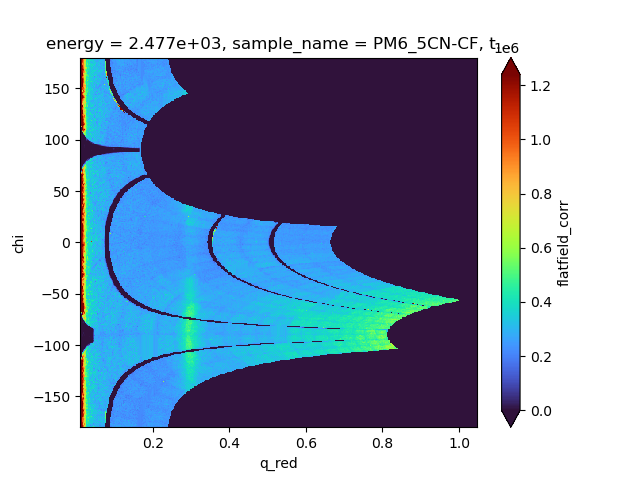

In [67]:
plt.close('all')
energy = 2477

DS = caked_DS.copy()
DA = DS['flatfield_corr'].sel(sample_name=sample_name, theta=theta)
DA = DA.sel(energy=energy,method='nearest').compute()

cmin = DA.quantile(0.01)
cmax = DA.quantile(0.995)

DA.plot.imshow(norm=plt.Normalize(cmin,cmax), cmap=plt.cm.turbo)
plt.show()

In [74]:
# (q_min, q_max, chi_min, chi_max)
nf_rois_dict = {
    'ROI_1': (0.11, 0.18, -16, 10),
    'ROI_2': (0.09, 0.14, -85, -65),
    'ROI_3': (0.13, 0.17, 138, 152),
    'ROI_4': (0.56, 0.61, -12.5, 5),
    'ROI_5': (0.66, 0.7, -82, -66),
    'ROI_6': (0.47, 0.78, -102, -38)
}

In [70]:
%matplotlib inline

In [71]:
plt.close('all')

  0%|          | 0/9 [00:00<?, ?it/s]

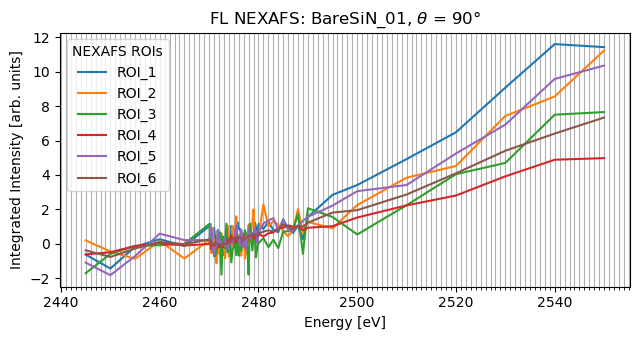

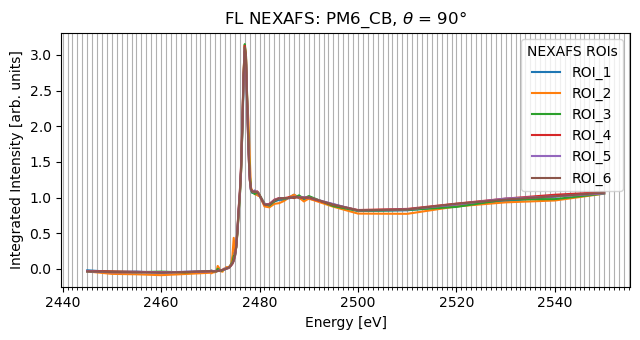


KeyboardInterrupt



In [77]:
# for nexafs ROI plotting!
DS = caked_DS.copy()

# make selection(s)
e_slice = slice(None, None)
# e_slice = slice(2465, 2490)


for sample_name in tqdm(unique_sample_names[:]):
    for theta in [90]:
        fig, ax = plt.subplots(figsize=(6.5, 3.5), tight_layout=True)
        for roi, extents_tuple in nf_rois_dict.items():
            q_min, q_max, chi_min, chi_max = extents_tuple
            
            DA = DS['flatfield_corr'].sel(sample_name=sample_name, theta=theta)
            DA = DA.where(DA>0.4).where(DA<(DA.max()*0.03))
            # # Subtract pre-peak flat line
            # para_DA = para_DA - para_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')
            # perp_DA = perp_DA - perp_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')

            # Mean/integrate chi/q:
            areas_DA = DA.sel(q_red=slice(q_min,q_max),chi=slice(chi_min,chi_max)).mean('chi').integrate('q_red')
            
            # Quick plot corrections: Subtract pre-edge mean, divide post-edge mean
            areas_DA = areas_DA - areas_DA.sel(energy=slice(2472, 2474)).mean('energy')  # subtract pre-edge
            areas_DA = areas_DA / areas_DA.sel(energy=slice(2485, 2488)).mean('energy')  # divide post-edge

            # Plot        
            # fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
            # areas_DA.sel(energy=e_slice).plot.line(ax=ax, label=f'{roi}: $\\chi$({chi_min},{chi_max}), Q({q_min}, {q_max})')
            areas_DA.sel(energy=e_slice).plot.line(ax=ax, label=f'{roi}')

            # fig.suptitle(f'FL NEXAFS {roi}: {sample_name} \n', x=0.53, y=0.95)

        ax.set_title(f'FL NEXAFS: {sample_name}, $\\theta$ = {theta}°')
        ax.set(ylabel=f'Integrated Intensity [arb. units]', xlabel='Energy [eV]')

        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.grid(True, which='both')
        ax.legend(title='NEXAFS ROIs')

        # savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots/nexafs_rois_vtesting')
        # savePath.mkdir(exist_ok=True)
        # fig.savefig(savePath.joinpath(
        #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}_energy{e_slice.start}-{e_slice.stop}.png'), dpi=120)

        plt.show()
        plt.close('all')

  0%|          | 0/8 [00:00<?, ?it/s]

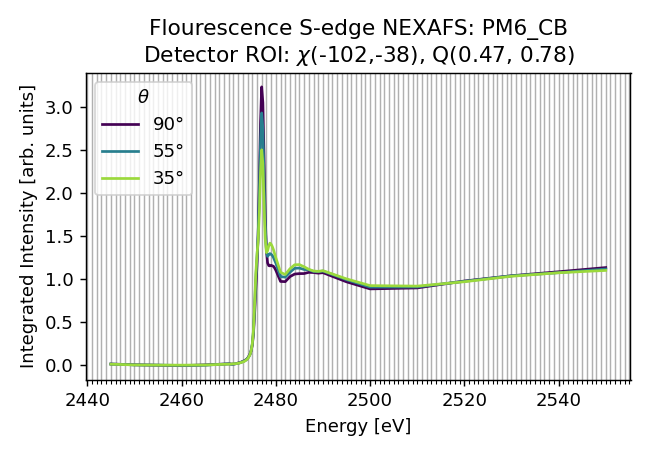

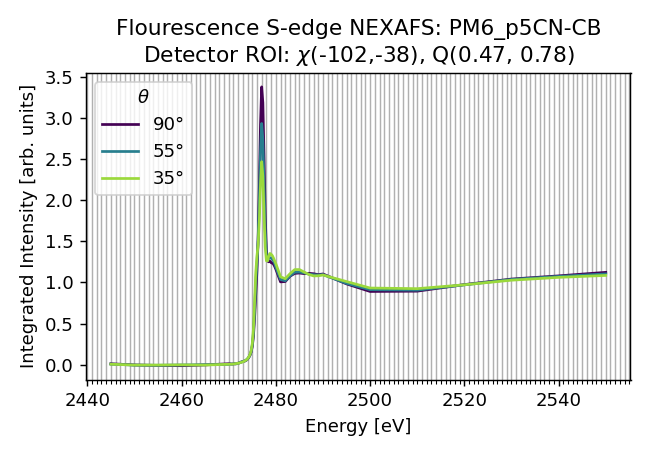

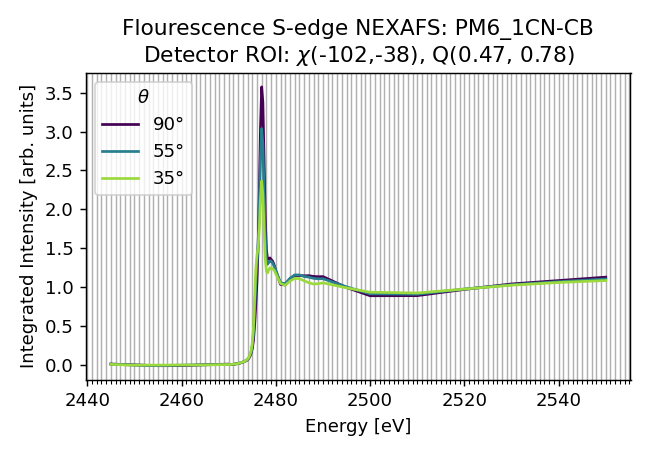

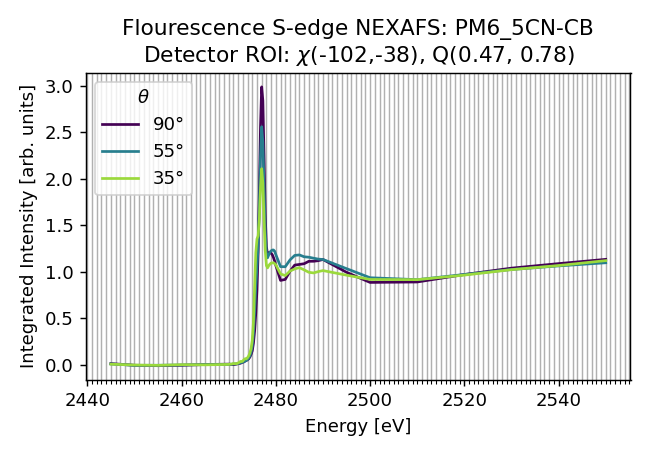

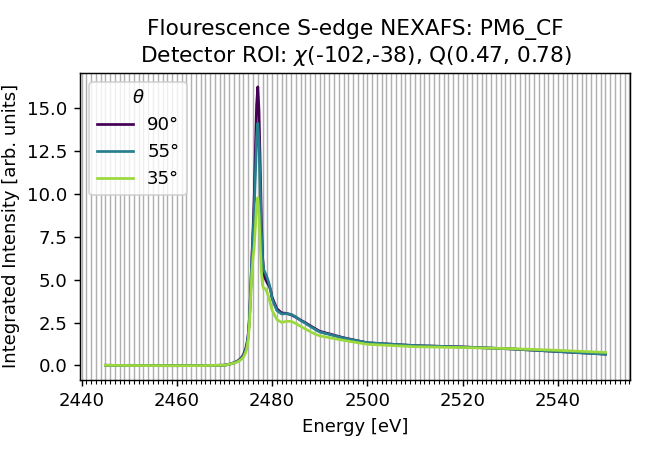

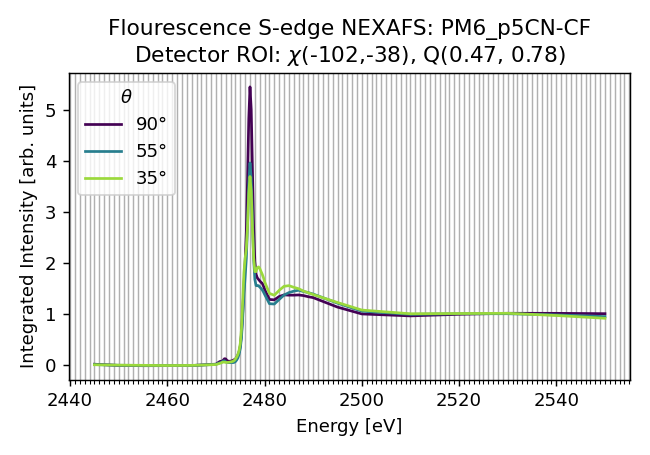

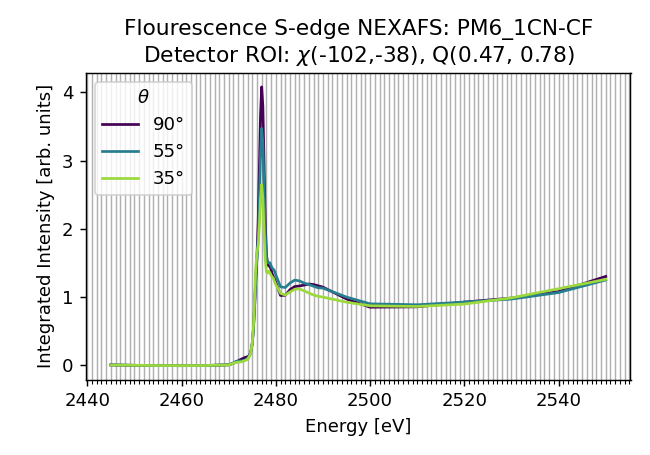

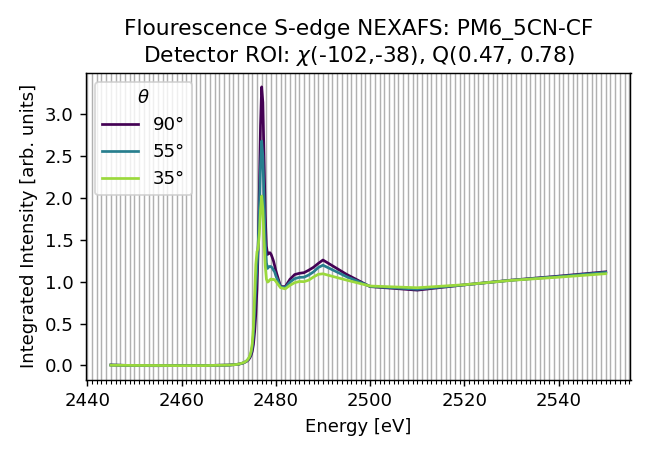

In [94]:
%matplotlib widget
plt.close('all')

# for nexafs selected ROI plotting!
DS = caked_DS.copy()
colors = plt.cm.viridis(np.linspace(0,0.85,3))

# make selection(s)
# e_slice = slice(None, None)
q_min, q_max, chi_min, chi_max = nf_rois_dict['ROI_6']
e_slice = slice(None, None)

for sample_name in tqdm(unique_sample_names[1:]):
    fig, ax = plt.subplots(figsize=(5, 3.5), tight_layout=True, dpi=130)
    for i, theta in enumerate([90, 55, 35]):
        DA = DS['flatfield_corr'].sel(sample_name=sample_name, theta=theta)
        DA = DA.where(DA>0.4).where(DA<(DA.max()*0.03))
        # # Subtract pre-peak flat line
        # para_DA = para_DA - para_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')
        # perp_DA = perp_DA - perp_DA.sel(q_red=slice(0.2,0.23)).mean('q_red')

        # Mean/integrate chi/q:
        areas_DA = DA.sel(q_red=slice(q_min,q_max),chi=slice(chi_min,chi_max)).mean('chi').integrate('q_red')

        # Quick plot corrections: Subtract pre-edge mean, divide post-edge mean
        # areas_DA = areas_DA - areas_DA.sel(energy=slice(2466, 2472)).mean('energy')  # subtract pre-edge, ah, not subtracting by line here...
        # areas_DA = areas_DA / areas_DA.sel(energy=slice(2500, 2520)).mean('energy')  # divide post-edge
        
        # Subtract pre-edge linear fit
        pre_edge = areas_DA.sel(energy=slice(None, 2470))
        pre_edge_polyfit = pre_edge.polyfit(dim='energy', deg=1).compute()
        pre_edge_line = xr.polyval(areas_DA.energy, pre_edge_polyfit['polyfit_coefficients'])
        
        # areas_DA.plot.line(ax=ax, color=colors[i], label=f'{theta}°')
        # pre_edge_line.plot.line(ax=ax)

        areas_DA = areas_DA - pre_edge_line
        
        # Divide post-edge mean
        areas_DA = areas_DA / areas_DA.sel(energy=slice(2500, None)).mean('energy')  # divide post-edge


        # Plot        
        areas_DA.sel(energy=e_slice).plot.line(ax=ax, color=colors[i], label=f'{theta}°')

        # fig.suptitle(f'FL NEXAFS {roi}: {sample_name} \n', x=0.53, y=0.95)

    ax.set_title(f'Flourescence S-edge NEXAFS: {sample_name}\n'+
                 f'Detector ROI: $\\chi$({chi_min},{chi_max}), Q({q_min}, {q_max})')
    ax.set(ylabel=f'Integrated Intensity [arb. units]', xlabel='Energy [eV]')

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.grid(True, which='both')
    ax.legend(title='$\\theta$', loc='upper left')

    # savePath = outPath.joinpath('trexs_plots/waxs_core_films_trexs_plots/nexafs_rois_vtesting')
    # savePath.mkdir(exist_ok=True)
    # fig.savefig(savePath.joinpath(
    #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}_energy{e_slice.start}-{e_slice.stop}.png'), dpi=120)

    plt.show()
    # plt.close('all')

In [91]:
DS['flatfield_corr'].sel(sample_name='PM6_1CN-CF', theta=90)

<xarray.DataArray 'flatfield_corr' (energy: 63, chi: 500, q_red: 500)> Size: 126MB
dask.array<getitem, shape=(63, 500, 500), dtype=float64, chunksize=(63, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * chi          (chi) float64 4kB -179.6 -178.9 -178.2 ... 178.2 178.9 179.6
  * energy       (energy) float64 504B 2.445e+03 2.45e+03 ... 2.54e+03 2.55e+03
    index_x      (q_red) int64 4kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
    index_y      (chi) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    q_r          (energy, q_red) float64 252kB dask.array<chunksize=(63, 500), meta=np.ndarray>
    sample_name  <U10 40B 'PM6_1CN-CF'
    theta        float64 8B 90.0
  * q_red        (q_red) float64 4kB 0.01104 0.01311 0.01518 ... 1.043 1.045
Attributes:
    bpm:                   bpm5.197
    detector:              WAXS.tif
    energy:                2445.00eV
    id:                    id519247
    misc:                  000000
    project:               TC
    rotation_from_normal:  prs55deg
    sample_number:         01
    sample_type:           Trmsn
    set_sdd:               sdd1.8m
    waxs_det_position:     wa0

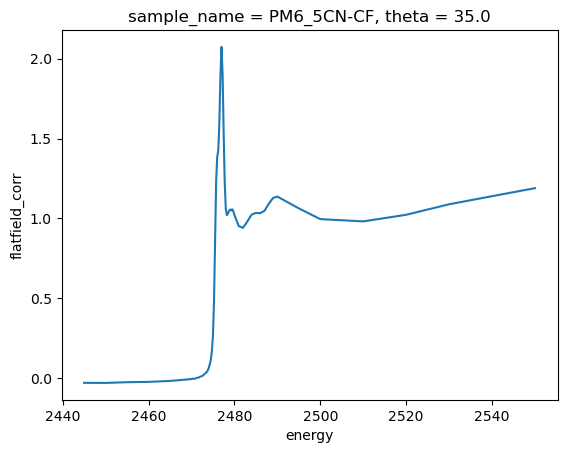

In [31]:
areas_DA.plot()

In [53]:
pre_edge = areas_DA.sel(energy=slice(2466, 2472))
pre_edge_polyfit = pre_edge.polyfit(dim='energy', deg=1).compute()
pre_edge_line = xr.polyval(areas_DA.energy, pre_edge_polyfit['polyfit_coefficients'])

In [45]:
pre_edge_polyfit['polyfit_coefficients']

<xarray.DataArray 'polyfit_coefficients' (degree: 2)> Size: 16B
array([ 6.78883141e-03, -1.67752024e+01])
Coordinates:
  * degree   (degree) int64 16B 1 0

In [42]:
pre_edge_DA.energy

<xarray.DataArray 'energy' (energy: 9)> Size: 72B
array([2470.  , 2470.25, 2470.5 , 2470.75, 2471.  , 2471.25, 2471.5 , 2471.75,
       2472.  ])
Coordinates:
  * energy       (energy) float64 72B 2.47e+03 2.47e+03 ... 2.472e+03 2.472e+03
    sample_name  <U10 40B 'PM6_5CN-CF'
    theta        float64 8B 35.0

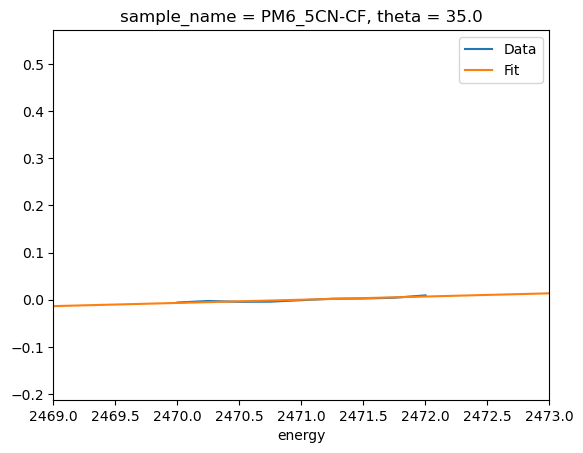

In [56]:
fig, ax = plt.subplots()
pre_edge_DA.plot(ax=ax, label='Data')
xr.polyval(areas_DA.energy, pre_edge_polyfit['polyfit_coefficients']).plot(ax=ax, label='Fit')
ax.set_xlim(2469, 2473)
ax.legend()
plt.show()

In [ ]:
savePath

## ISI Plots

In [ ]:
# DA = rsoxs_datasets['polar_carbon']['corr_intensity']
# DA.sel(sample_name='Y6_CB_3000', polarization=0, q=slice(0.001, 0.03)).sel(energy=398.8, method='nearest').plot(norm=LogNorm(1e9, 1e11), cmap=plt.cm.turbo)
# plt.show()

In [ ]:
outPath

In [ ]:
DS.energy

In [ ]:
# make selection
DS = caked_DS.copy()

# make selection
q_slice = slice(0.05, 0.8)
chi_width = 90
# energy_slice = slice(2470, 2485)
energy_slice = slice(None, None)


for sample_name in tqdm(unique_sample_names[3:5]):
    for theta in [90, 55, 35]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')
    

        # slice ISI data
        para_ISI = para_DA.sel(q_red=q_slice).mean('chi').integrate('q_red')
        perp_ISI = perp_DA.sel(q_red=q_slice).mean('chi').integrate('q_red')

        # plot
        fig, ax = plt.subplots(figsize=(6,4), dpi=120)

        para_ISI.sel(energy=energy_slice).plot.line(ax=ax, label='$\parallel$', yscale='log')
        perp_ISI.sel(energy=energy_slice).plot.line(ax=ax, label='$\perp$', yscale='log')
        fig.suptitle(f'ISI: {sample_name}', fontsize=14, x=0.55)
        ax.set(title=f'$\\theta$ = {theta}°, chi width = {chi_width}°, Q = ({q_slice.start}, {q_slice.stop}) ' + 'Å$^{-1}$', 
               xlabel='X-ray energy [eV]', ylabel='Intensity [arb. units]')
        ax.legend(loc='upper right', fontsize=14)
        ax.grid(axis='x')
        plt.subplots_adjust(top=0.86, bottom=0.2, left=0.2)
        
        # fig.savefig(outPath.joinpath('trexs_plots/ISIs_v1', 
        #     f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}_energy{energy_slice.start}-{energy_slice.stop}.png'),
        #     dpi=120)

        plt.show()
        plt.close('all')

## 2D Linecut Maps

In [ ]:
# make selection
DS = caked_DS.copy()

# make selection
q_slice = slice(0.05, 0.8)
chi_width = 90
energy_slice = slice(2470, 2485)

for sample_name in tqdm(unique_sample_names):
    for theta in [90, 55, 35]:
        para_DA, perp_DA = make_para_perp_DAs(DS, sample_name, theta, chi_width) 
        
        para_DA = para_DA.where(para_DA>0.4).where(para_DA<(para_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # para_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('para')
        # plt.show()
        
        perp_DA = perp_DA.where(perp_DA>0.4).where(perp_DA<(perp_DA.max()*0.03))  #.interpolate_na(dim='chi')
        # perp_DA.sel(energy=2477.2,method='nearest').sel(q_red=slice(0.05, 0.7)).plot.imshow()
        # plt.title('perp')
        # plt.show()
        # plt.close('all')

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        cmin = float(para_DA.compute().quantile(0.1))
        cmax = float(para_DA.compute().quantile(0.99))

        para_slice = para_DA.mean('chi').sel(q_red=q_slice, energy=energy_slice)  # .plot(ax=axs[0], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)
        perp_slice = perp_DA.mean('chi').sel(q_red=q_slice, energy=energy_slice)  # .plot(ax=axs[1], cmap=cmap, norm=LogNorm(cmin, cmax), add_colorbar=False)

        para_slice.plot(ax=axs[0], cmap=cmap, norm=plt.Normalize(cmin, cmax), add_colorbar=False)
        perp_slice.plot(ax=axs[1], cmap=cmap, norm=plt.Normalize(cmin, cmax), add_colorbar=False)

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(cmin, cmax)) # Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
        cax = axs[1].inset_axes([1.03, 0, 0.05, 1])
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_label(label='Intensity [arb. units]', labelpad=12, rotation=270)

        fig.suptitle(f'Intensity maps: {sample_name}, $\\theta$ = {theta}°, $\\chi$ width = {chi_width}°', fontsize=14)
        fig.set(tight_layout=True)

        axs[0].set(xscale='linear', title='Parallel to $E_p$', ylabel='Photon energy [eV]', xlabel='Q [$Å^{-1}$]')
        axs[1].set(xscale='linear', title='Perpendicular to $E_p$ ', ylabel=None, xlabel='Q [$Å^{-1}$]')

        fig.savefig(outPath.joinpath('trexs_plots/I_maps_v1', 
                    f'{sample_name}_theta-{theta}deg_chiWidth-{chi_width}deg_q-{q_slice.start}-{q_slice.stop}_energy{energy_slice.start}-{energy_slice.stop}.png'), 
                    dpi=120)

        # plt.show()
        plt.close('all')

In [ ]:
# a = para_EvsQ_avg.hvplot.line(groupby="energy", loglog=True)
# a * perp_EvsQ_avg.hvplot.line(groupby="energy")

# Misc code

In [ ]:
# Solution saxs volume fraction math:
# General equation: scale = phi (relative volume fraction) / volume_scatterer

scale_a = 0.01
radius_a = 140  # Å
h_a = 1000  # Å

scale_b = 0.99
radius_b = 7.5  # Å
h_b = 1000  # Å

# Calculate cylinder volume
cylinder_a = h_a * np.pi * (radius_a**2)
cylinder_b = h_b * np.pi * (radius_b**2)

# Calculate relative volume fractions
phi_a = scale_a * cylinder_a
phi_b = scale_b * cylinder_b

# Get real volume fractions 
vfrac_b = phi_b/phi_a
vfrac_a = 1 - vfrac_b

# Print Results
print(f'Volume percent of population A (large fibrils): {np.round(vfrac_a*100,0).astype(int)}%')
print(f'Volume percent of population B (individual polymer): {np.round(vfrac_b*100,0).astype(int)}%')